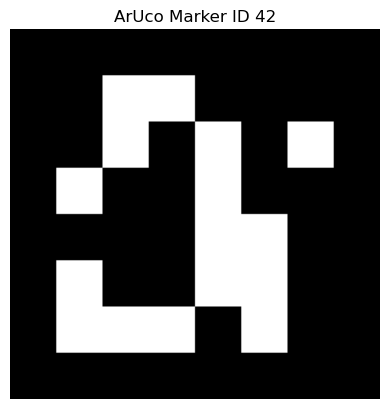

Marker saved as aruco_marker.png


In [1]:
# ArUco Marker Generation and Pose Detection
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Pick dictionary
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_250)

marker_id = 42
marker_size = 200

# New function in OpenCV ≥4.10
marker_img = cv2.aruco.generateImageMarker(aruco_dict, marker_id, marker_size)

plt.imshow(marker_img, cmap='gray')
plt.title(f"ArUco Marker ID {marker_id}")
plt.axis('off')
plt.show()

cv2.imwrite("aruco_marker.png", marker_img)
print("Marker saved as aruco_marker.png")


In [ ]:
import cv2
import numpy as np

# Load dictionary
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_250)

# Create detector parameters
parameters = cv2.aruco.DetectorParameters()
detector = cv2.aruco.ArucoDetector(aruco_dict, parameters)

# Marker real-world size in METERS
marker_length = 0.09  # 10 cm = 0.11 meters

print("\n" + "="*50)
print("Starting ArUco Detection...")
print("Camera Position Relative to Marker (Horizontal Plane)")
print("="*50)
print("Controls:")
print("  ESC - Quit")
print("  'c' - Capture current pose")
print("="*50 + "\n")

# Open webcam (adjust index if needed)
cap = cv2.VideoCapture(1)  # Change to your C920 index

# Set resolution for C920
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)

# Check if camera opened successfully
if not cap.isOpened():
    print("Error: Could not open webcam")
    exit()

# Get actual camera resolution
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
print(f"Camera resolution: {frame_width}x{frame_height}")

# Camera calibration matrix for Logitech C920 (approximate)
fx = fy = frame_width * 1.2  # Focal length approximation
cx = frame_width / 2  # Principal point X (center of image)
cy = frame_height / 2  # Principal point Y (center of image)

camera_matrix = np.array([[fx,  0, cx],
                          [ 0, fy, cy],
                          [ 0,  0,  1]], dtype=float)
dist_coeffs = np.zeros((5, 1))

print(f"Camera matrix principal point: ({cx}, {cy})")
print(f"Focal length: {fx}\n")

print("Reference Frame:")
print("  Marker is at origin (0, 0, 0) on horizontal plane")
print("  Blue axis (Z) = Forward direction (0° heading)")
print("  Green axis (Y) = Left/Right direction")
print("  Red axis (X) = Up/Down direction")
print("="*50 + "\n")

while True:
    ret, frame = cap.read()
    if not ret:
        print("Error: Failed to grab frame")
        break

    # Convert to grayscale for better detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect markers
    corners, ids, rejected = detector.detectMarkers(gray)

    # Draw green dot at camera center (screen center)
    screen_center_x = int(frame_width / 2)
    screen_center_y = int(frame_height / 2)
    cv2.circle(frame, (screen_center_x, screen_center_y), 5, (0, 255, 0), -1)

    if ids is not None:
        # Draw detected markers
        cv2.aruco.drawDetectedMarkers(frame, corners, ids)

        # Process each detected marker
        for i, corner in enumerate(corners):
            # Get the marker ID
            marker_id = ids[i][0]
            
            # Calculate marker center
            marker_center_x = int(np.mean(corner[0][:, 0]))
            marker_center_y = int(np.mean(corner[0][:, 1]))
            
            # Draw red dot at marker center
            cv2.circle(frame, (marker_center_x, marker_center_y), 5, (0, 0, 255), -1)
            
            # Define 3D coordinates of marker corners in marker coordinate system
            obj_points = np.array([
                [-marker_length/2,  marker_length/2, 0],
                [ marker_length/2,  marker_length/2, 0],
                [ marker_length/2, -marker_length/2, 0],
                [-marker_length/2, -marker_length/2, 0]
            ], dtype=np.float32)
            
            # Solve PnP to get rotation and translation vectors
            # This gives us marker pose relative to camera
            success, rvec_marker_to_cam, tvec_marker_to_cam = cv2.solvePnP(
                obj_points,
                corner[0],
                camera_matrix,
                dist_coeffs,
                flags=cv2.SOLVEPNP_IPPE_SQUARE
            )
            
            if success:
                # Draw axis on the marker
                cv2.drawFrameAxes(frame, camera_matrix, dist_coeffs, 
                                rvec_marker_to_cam, tvec_marker_to_cam, marker_length * 0.5)
                
                # Convert rotation vector to rotation matrix (marker to camera)
                R_marker_to_cam, _ = cv2.Rodrigues(rvec_marker_to_cam)
                
                # INVERT THE TRANSFORMATION
                # We want camera position relative to marker, not marker relative to camera
                R_cam_to_marker = R_marker_to_cam.T  # Transpose = Inverse for rotation matrix
                tvec_cam_to_marker = -R_cam_to_marker @ tvec_marker_to_cam
                
                # Extract camera position in marker's coordinate system
                x_cam = tvec_cam_to_marker[0][0]  # Red axis (Up/Down)
                y_cam = tvec_cam_to_marker[1][0]  # Green axis (Left/Right)
                z_cam = tvec_cam_to_marker[2][0]  # Blue axis (Forward/Backward)
                
                # Calculate horizontal distance (ignoring height)
                horizontal_distance = np.sqrt(y_cam**2 + z_cam**2)
                total_distance = np.linalg.norm(tvec_cam_to_marker)
                
                # Calculate camera orientation (Euler angles) relative to marker
                # Using ZYX convention (Yaw-Pitch-Roll)
                
                # Yaw (rotation around blue/Z axis - heading direction)
                yaw = np.arctan2(R_cam_to_marker[1, 0], R_cam_to_marker[0, 0])
                
                # Pitch (rotation around red/X axis - looking up/down)
                pitch = np.arctan2(-R_cam_to_marker[2, 0], 
                                   np.sqrt(R_cam_to_marker[2, 1]**2 + R_cam_to_marker[2, 2]**2))
                
                # Roll (rotation around green/Y axis - tilting left/right)
                roll = np.arctan2(R_cam_to_marker[2, 1], R_cam_to_marker[2, 2])
                
                # Convert to degrees
                yaw_deg = np.degrees(yaw)
                pitch_deg = np.degrees(pitch)
                roll_deg = np.degrees(roll)
                
                # Calculate heading angle in horizontal plane (relative to blue axis)
                heading_angle = np.degrees(np.arctan2(y_cam, z_cam))
                
                # Draw creamy background box for text
                overlay = frame.copy()
                cv2.rectangle(overlay, (5, 5), (450, 480), (230, 245, 255), -1)  # Creamy color
                cv2.rectangle(overlay, (5, 5), (450, 480), (180, 200, 220), 2)  # Border
                frame = cv2.addWeighted(overlay, 0.85, frame, 0.15, 0)
                
                # Display information on frame
                y_offset = 30
                cv2.putText(frame, f"Marker ID: {marker_id}", (10, y_offset), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 97, 100), 2)
                
                y_offset += 35
                cv2.putText(frame, f"Camera Position (relative to marker):", (10, y_offset), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 139), 2)
                
                y_offset += 30
                cv2.putText(frame, f"  Side (X-Red):  {x_cam:.3f}m ({x_cam*100:.1f}cm)", 
                           (10, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
                
                y_offset += 30
                cv2.putText(frame, f"  Forward (Y-Green):  {y_cam:.3f}m ({y_cam*100:.1f}cm)", 
                           (10, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 100, 0), 2)
                
                y_offset += 30
                cv2.putText(frame, f"  Height (Z-Blue): {z_cam:.3f}m ({z_cam*100:.1f}cm)", 
                           (10, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
                
                y_offset += 35
                cv2.putText(frame, f"Horizontal Dist: {horizontal_distance:.3f}m ({horizontal_distance*100:.1f}cm)", 
                           (10, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 139), 2)
                
                y_offset += 30
                cv2.putText(frame, f"Heading: {heading_angle:.1f}deg from blue axis", 
                           (10, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 139), 2)
                
                y_offset += 35
                cv2.putText(frame, f"Correction Inputs (Camera Orientation):", (10, y_offset), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 139), 2)
                
                y_offset += 30
                cv2.putText(frame, f"  Yaw Correction (Z-Blue):   {yaw_deg:+.1f}deg", 
                           (10, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
                
                y_offset += 30
                cv2.putText(frame, f"  Pitch Correction (X-Red):  {(roll_deg + 180):+.1f}deg", 
                           (10, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
                
                y_offset += 30
                cv2.putText(frame, f"  Roll Correction (Y-Green): {pitch_deg:+.1f}deg", 
                           (10, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 100, 0), 2)
                
                y_offset += 35
                cv2.putText(frame, f"Dots:", (10, y_offset), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 139), 2)
                
                y_offset += 30
                cv2.putText(frame, f"  Red = Marker Center", 
                           (10, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
                
                y_offset += 30
                cv2.putText(frame, f"  Green = Camera Center", 
                           (10, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 100, 0), 2)
                
                # Print to console
                print(f"\n{'='*70}")
                print(f"Marker ID: {marker_id}")
                print(f"{'='*70}")
                print(f"CAMERA POSITION (relative to marker at origin):")
                print(f"  X (Side - Red axis):     {x_cam:+.3f}m ({x_cam*100:+6.1f}cm)")
                print(f"  Y (Forward - Green axis):     {y_cam:+.3f}m ({y_cam*100:+6.1f}cm)")
                print(f"  Z (Height - Blue axis):   {z_cam:+.3f}m ({z_cam*100:+6.1f}cm)")
                print(f"\nDISTANCES:")
                print(f"  Horizontal distance:       {horizontal_distance:.3f}m ({horizontal_distance*100:.1f}cm)")
                print(f"  Total 3D distance:         {total_distance:.3f}m ({total_distance*100:.1f}cm)")
                print(f"  Heading from blue axis:    {heading_angle:+.1f}°")
                print(f"\nCAMERA ORIENTATION (angles):")
                print(f"  Yaw   (around Blue/Z):     {yaw_deg:+7.1f}°  (heading rotation)")
                print(f"  Pitch (around Red/X):      {roll_deg:+7.1f}°  (looking up/down)")
                print(f"  Roll  (around Green/Y):    {pitch_deg:+7.1f}°  (tilting left/right)")
                print(f"{'='*70}\n")
                
    else:
        # Display instructions when no marker is detected
        cv2.putText(frame, "No marker detected - Show ArUco marker ID 42 to camera", 
                   (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    # Display the frame
    cv2.imshow("ArUco Pose Detection - Camera Position", frame)
    
    # Handle key presses
    key = cv2.waitKey(1) & 0xFF
    if key == 27:  # ESC to quit
        print("\nExiting...")
        break
    elif key == ord('c'):
        if ids is not None:
            print("\n" + "🔖 "*20)
            print("CALIBRATION POINT CAPTURED!")
            print("🔖 "*20)

# Cleanup
cap.release()
cv2.destroyAllWindows()
print("✓ Camera released and windows closed")


Starting ArUco Detection...
Camera Position Relative to Marker (Horizontal Plane)
Controls:
  ESC - Quit
  'c' - Capture current pose

Camera resolution: 1920x1080
Camera matrix principal point: (960.0, 540.0)
Focal length: 2304.0

Reference Frame:
  Marker is at origin (0, 0, 0) on horizontal plane
  Blue axis (Z) = Forward direction (0° heading)
  Green axis (Y) = Left/Right direction
  Red axis (X) = Up/Down direction


Marker ID: 164
CAMERA POSITION (relative to marker at origin):
  X (Side - Red axis):     +6.699m (+669.9cm)
  Y (Forward - Green axis):     -0.293m ( -29.3cm)
  Z (Height - Blue axis):   +0.739m ( +73.9cm)

DISTANCES:
  Horizontal distance:       0.795m (79.5cm)
  Total 3D distance:         6.746m (674.6cm)
  Heading from blue axis:    -21.7°

CAMERA ORIENTATION (angles):
  Yaw   (around Blue/Z):      -107.5°  (heading rotation)
  Pitch (around Red/X):        +83.0°  (looking up/down)
  Roll  (around Green/Y):       +4.5°  (tilting left/right)


Marker ID: 42
CAMER

KeyboardInterrupt: 